In [1]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow import keras
from keras.models import load_model
from keras import backend as K

In [2]:
batch_size = 64
# Creating a generator for the training set
# Rescaling images
train_datagen = ImageDataGenerator(rescale=1/255)
# Flowing images from my local directory
train_generator = train_datagen.flow_from_directory(
        '/home/kenan/Desktop/COV19D/train/',  # Source directory for training images
        target_size=(512, 512),  # Images are 512x512
        batch_size=batch_size,  # The batch size
        classes = ['covid','non-covid'], # Tow classes
        class_mode='binary') # Binary Task

Found 335672 images belonging to 2 classes.


In [3]:
# Creating a similar generator for the validation set
val_datagen = ImageDataGenerator(rescale=1/255)
val_generator = val_datagen.flow_from_directory(
        '/home/kenan/Desktop/COV19D/validation/',  
        target_size=(512, 512),  
        batch_size=batch_size,
        classes = ['covid','non-covid'],
        class_mode='binary')

Found 75532 images belonging to 2 classes.


In [6]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [4]:
val_generator.classes 

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [7]:
# Building a CNN model 
model = tf.keras.models.Sequential([
    # The first convolution 
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(512, 512, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(.2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(.2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(.2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(.2),
    # flatten layer
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(128, activation='relu'),
    # Binary outputs for the task
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)       

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 510, 510, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 255, 255, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 253, 253, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 124, 124, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0

In [9]:
# Defining macro f1 measure as a loss function
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())

    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    
    return 1 - K.mean(f1)

In [32]:
total_sample=train_generator.n
n_epochs = 200
steps_per_epoch = len(train_generator) // batch_size

In [29]:
# Importing saved models from check points or from .h5 files
checkpoint_path = '/home/kenan/Desktop/COV19D/ckpts/'
# model_2 = load_model('/home/kenan/Desktop/COV19D/ckpts/model_1.h5',  custom_objects={'f1_loss':f1_loss, 'f1':f1})

In [30]:
# Adding check points to save work locally 
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_freq=100)

In [31]:
# Compiling the model
model.compile(optimizer='adam', loss=f1_loss, metrics=['accuracy', f1])

In [33]:
# Training thee model
history=model.fit_generator(generator=train_generator, 
                            steps_per_epoch=steps_per_epoch, 
                            validation_data=val_generator, 
                            validation_steps=steps_per_epoch, 
                            epochs=n_epochs,
                            callbacks=[cp_callback])

Epoch 1/200
81/81 [==============================] - 484s 6s/step - loss: 0.3015 - accuracy: 0.5398 - f1: 0.6985 - val_loss: 0.3040 - val_accuracy: 0.5357 - val_f1: 0.6960
Epoch 2/200
19/81 [======>.......................] - ETA: 4:53 - loss: 0.2878 - accuracy: 0.5553 - f1: 0.7122
Epoch 00002: saving model to /home/kenan/Desktop/COV19D/ckpts/
INFO:tensorflow:Assets written to: /home/kenan/Desktop/COV19D/ckpts/assets
81/81 [==============================] - 485s 6s/step - loss: 0.2969 - accuracy: 0.5445 - f1: 0.7031 - val_loss: 0.3024 - val_accuracy: 0.5386 - val_f1: 0.6976
Epoch 3/200
38/81 [=============>................] - ETA: 3:25 - loss: 0.3009 - accuracy: 0.5396 - f1: 0.6991
Epoch 00003: saving model to /home/kenan/Desktop/COV19D/ckpts/
INFO:tensorflow:Assets written to: /home/kenan/Desktop/COV19D/ckpts/assets
81/81 [==============================] - 487s 6s/step - loss: 0.3042 - accuracy: 0.5359 - f1: 0.6958 - val_loss: 0.2949 - val_accuracy: 0.5465 - val_f1: 0.7051
Epoch 4/200


In [34]:
# Saving the model locally as an 'h5' formated file
model_1 = model.save('/home/kenan/Desktop/COV19D/ckpts/model_2.h5')

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
macro_f1 = history.history['f1']
val_macro_f1 = history.history['val_f1']

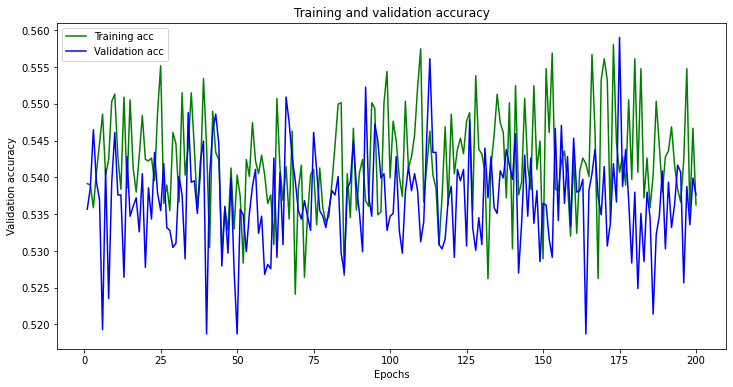

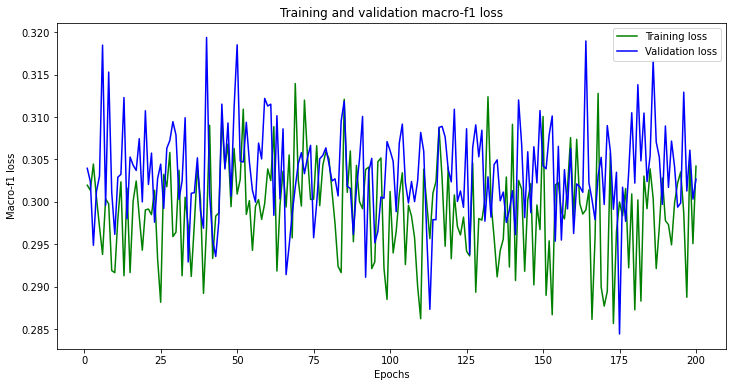

In [54]:
epochs = range(1, len(acc)+1)

plt.figure(figsize=(12,6))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.legend()

plt.figure(figsize=(12,6))

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation macro-f1 loss')
plt.xlabel('Epochs')
plt.ylabel('Macro-f1 loss')
plt.legend()

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

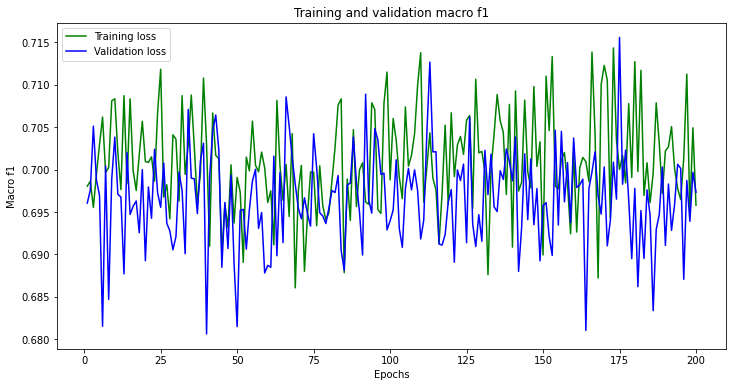

In [53]:
plt.figure(figsize=(12,6))
plt.plot(epochs, macro_f1, 'g', label='Training loss')
plt.plot(epochs, val_macro_f1, 'b', label='Validation loss')
plt.title('Training and validation macro f1')
plt.xlabel('Epochs')
plt.ylabel('Macro f1')
plt.legend()

plt.show